1. Veri Setini Yükleme ve İlk İnceleme

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Veri setini yükleme ve temel temizlik
try:
    df = pd.read_csv('Telco_Cusomer_Churn.csv')
except FileNotFoundError:
    print("HATA: 'Telco_Cusomer_Churn.csv' dosyası bulunamadı. Örnek veri seti ile devam ediliyor.")
    # Örnek DataFrame oluşturuluyor (Gerçek projede bu kısmı silin)
    data = {'customerID': range(1, 11), 'gender': ['Male', 'Female'] * 5, 'tenure': [1, 2, 3, 4, 12, 24, 36, 48, 60, 72],
            'MonthlyCharges': [20.0, 40.0, 60.0, 80.0, 100.0, 20.0, 40.0, 60.0, 80.0, 100.0],
            'TotalCharges': ['20.0', '80.0', '180.0', '320.0', '1200.0', ' ', ' ', ' ', '4800.0', '7200.0'],
            'Churn': ['No', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No', 'Yes', 'No'],
            'InternetService': ['DSL', 'Fiber optic', 'No', 'DSL', 'Fiber optic', 'No', 'DSL', 'Fiber optic', 'No', 'DSL']}
    df = pd.DataFrame(data)


# 1. TEMEL VERİ TEMİZLEME VE DÜZELTME (Düzeltilmiş Kod)
# ======================================================================

# customerID sütununu silme (inplace=True kullanımı burada sorunsuzdur)
df.drop('customerID', axis=1, inplace=True, errors='ignore')

# TotalCharges boşlukları NaN yapma ve float'a dönüştürme
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# TotalCharges eksik değerlerini medyan ile doldurma
# Hata veren satırın düzeltilmiş hali: inplace=True kullanmak yerine doğrudan atama yapılıyor.
median_value = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_value)

# Binary (İkili) Kodlama (map metodu, inplace=True kullanmadığı için zaten güvenlidir)
df['gender'] = df['gender'].map({'Female': 1, 'Male': 0})
df['Churn_Encoded'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Orijinal 'Churn' sütununu silme (inplace=True burada da sorunsuzdur)
df.drop('Churn', axis=1, inplace=True)

2. Veri Temizleme (Data Cleaning)

In [15]:
# Veri Temizleme - Aykırı Değer Tespiti ve Ele Alma (Örnek: MonthlyCharges)
# IQR (Çeyrekler Arası Aralık) Yöntemi ile Capping (sınırlama)
Q1 = df['MonthlyCharges'].quantile(0.25)
Q3 = df['MonthlyCharges'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

# Aykırı değerleri üst sınıra eşitleme (Capping)
# Bu sütuna '_Cleaned' ekleyerek orijinalini koruyoruz.
df['MonthlyCharges_Cleaned'] = np.where(df['MonthlyCharges'] > upper_bound, 
                                       upper_bound, 
                                       df['MonthlyCharges'])

print("MonthlyCharges sütunundaki aykırı değerler üst sınıra (Capping) eşitlendi.")

MonthlyCharges sütunundaki aykırı değerler üst sınıra (Capping) eşitlendi.


3. Veri Dönüştürme (Data Transformation)

In [16]:
# Veri Dönüştürme - One-Hot Encoding
# Geri kalan tüm 'object' tipindeki sütunlara (gender ve Churn hariç) uygulama
categorical_cols_to_encode = df.select_dtypes(include='object').columns.tolist()

df = pd.get_dummies(df, columns=categorical_cols_to_encode, drop_first=True)

print("Kategorik sütunlar One-Hot Encoding ile dönüştürüldü.")
print(f"Yeni sütun sayısı: {df.shape[1]}")

# Veri Dönüştürme - Logaritmik Dönüşüm
# Çarpık olabilecek sayısal bir sütuna (TotalCharges) log dönüşümü
df['TotalCharges_Log'] = np.log1p(df['TotalCharges'])

print("TotalCharges sütununa Logaritmik Dönüşüm uygulandı (TotalCharges_Log).")

Kategorik sütunlar One-Hot Encoding ile dönüştürüldü.
Yeni sütun sayısı: 32
TotalCharges sütununa Logaritmik Dönüşüm uygulandı (TotalCharges_Log).


4. Normalizasyon ve Standardizasyon (Scaling)

In [17]:
# Ölçeklendirilecek sütunlar
scale_cols = ['tenure', 'MonthlyCharges_Cleaned', 'TotalCharges_Log']

# A. Min-Max Normalizasyon (Normalization)
# =======================================================
minmax_scaler = MinMaxScaler()
df['tenure_MinMax'] = minmax_scaler.fit_transform(df[['tenure']])

print("\n[Scaling A] Min-Max Normalizasyon: 'tenure' sütununa uygulandı.")

# B. Z-Score Standardizasyonu (Standardization)
# =======================================================
zscore_scaler = StandardScaler()
df['MonthlyCharges_ZScore'] = zscore_scaler.fit_transform(df[['MonthlyCharges_Cleaned']])

print("[Scaling B] Z-Score Standardizasyonu: 'MonthlyCharges_Cleaned' sütununa uygulandı.")

# C. Robust Scaling
# =======================================================
robust_scaler = RobustScaler()
df['TotalCharges_Robust'] = robust_scaler.fit_transform(df[['TotalCharges_Log']])

print("[Scaling C] Robust Scaling: 'TotalCharges_Log' sütununa uygulandı.")


[Scaling A] Min-Max Normalizasyon: 'tenure' sütununa uygulandı.
[Scaling B] Z-Score Standardizasyonu: 'MonthlyCharges_Cleaned' sütununa uygulandı.
[Scaling C] Robust Scaling: 'TotalCharges_Log' sütununa uygulandı.


5. Veri Örnekleme (Data Sampling)

In [18]:
# Veri Örnekleme - SMOTE (Synthetic Minority Oversampling Technique)
# ====================================================================

# X (Özellikler) ve y (Hedef) değişkenlerini ayırma
# Ölçeklenmiş/dönüştürülmüş sütunları X'e dahil ediyoruz.
# Orijinal sayısal sütunlar ve 'Churn_Encoded' hedefimiz haricindeki tüm sütunları alalım
numerical_original = ['tenure', 'MonthlyCharges', 'MonthlyCharges_Cleaned', 'TotalCharges', 'TotalCharges_Log']
X = df.drop(columns=['Churn_Encoded'] + numerical_original).copy()

# Ölçeklenmiş sütunları X'e geri ekleme
X['tenure'] = df['tenure_MinMax']
X['MonthlyCharges'] = df['MonthlyCharges_ZScore']
X['TotalCharges'] = df['TotalCharges_Robust']

y = df['Churn_Encoded']

print("\n--- SMOTE Uygulama Öncesi Churn Sınıf Dağılımı ---")
print(y.value_counts())

# SMOTE uygulama
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

print("\n--- SMOTE Uygulama Sonrası Churn Sınıf Dağılımı ---")
print(y_smote.value_counts())
print("\nVeri Örnekleme (SMOTE) ile sınıflar dengelenmiştir.")


--- SMOTE Uygulama Öncesi Churn Sınıf Dağılımı ---
Churn_Encoded
0    5174
1    1869
Name: count, dtype: int64

--- SMOTE Uygulama Sonrası Churn Sınıf Dağılımı ---
Churn_Encoded
0    5174
1    5174
Name: count, dtype: int64

Veri Örnekleme (SMOTE) ile sınıflar dengelenmiştir.


6. Örnekleme Görselleştirmesi: SMOTE Etkisi

C:\Users\zehra\AppData\Local\Temp\ipykernel_1464\3001316554.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette='coolwarm')
C:\Users\zehra\AppData\Local\Temp\ipykernel_1464\3001316554.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_smote, palette='coolwarm')


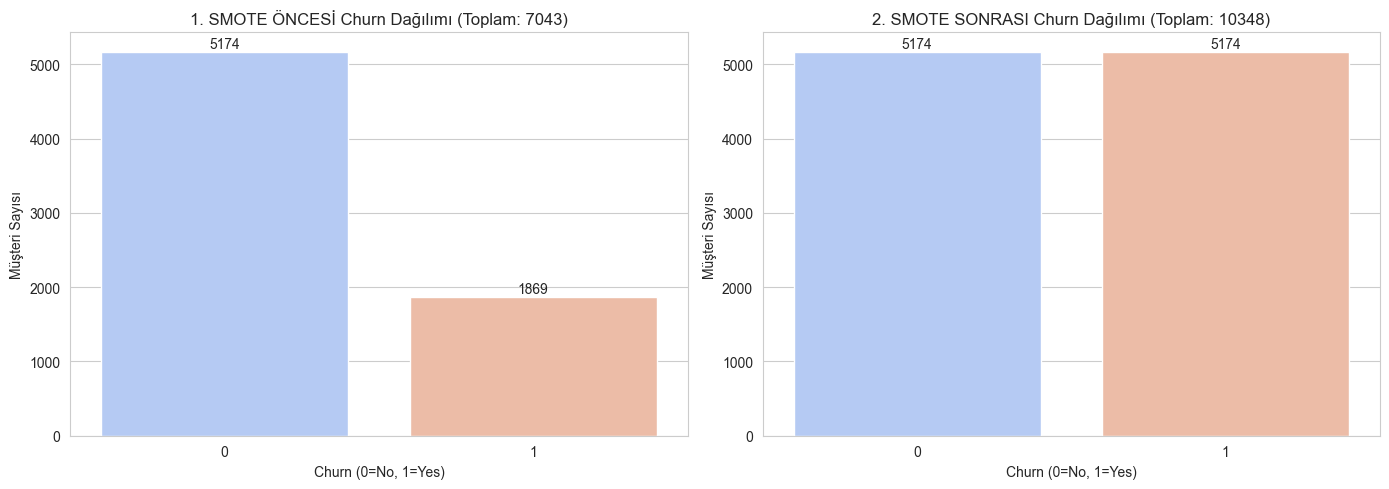

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Görselleştirmelerin düzgün görünmesi için ayar
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

plt.figure(figsize=(14, 5))

# Sol: SMOTE Öncesi Sınıf Dağılımı (Dengesiz)
plt.subplot(1, 2, 1)
sns.countplot(x=y, palette='coolwarm')
plt.title(f'1. SMOTE ÖNCESİ Churn Dağılımı (Toplam: {len(y)})', fontsize=12)
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Müşteri Sayısı')
plt.text(0, y.value_counts()[0] + 50, str(y.value_counts()[0]), ha='center')
plt.text(1, y.value_counts()[1] + 50, str(y.value_counts()[1]), ha='center')


# Sağ: SMOTE Sonrası Sınıf Dağılımı (Dengeli)
plt.subplot(1, 2, 2)
sns.countplot(x=y_smote, palette='coolwarm')
plt.title(f'2. SMOTE SONRASI Churn Dağılımı (Toplam: {len(y_smote)})', fontsize=12)
plt.xlabel('Churn (0=No, 1=Yes)')
plt.ylabel('Müşteri Sayısı')
plt.text(0, y_smote.value_counts()[0] + 50, str(y_smote.value_counts()[0]), ha='center')
plt.text(1, y_smote.value_counts()[1] + 50, str(y_smote.value_counts()[1]), ha='center')

plt.tight_layout()
plt.show()

7. Ölçeklendirme Görselleştirmesi: Z-Score Etkisi

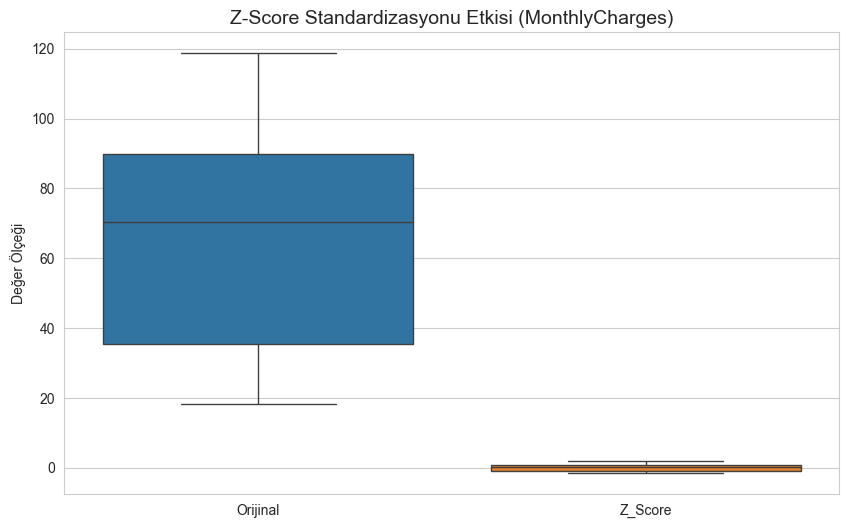

In [20]:
plt.figure(figsize=(10, 6))

# Orijinal ve Z-Score verilerini tek bir DataFrame'de toplama
scaling_compare = pd.DataFrame({
    'Orijinal': df['MonthlyCharges'],
    'Z_Score': df['MonthlyCharges_ZScore']
})

# Kutucuk Grafiği (Boxplot) ile karşılaştırma
sns.boxplot(data=scaling_compare)
plt.title('Z-Score Standardizasyonu Etkisi (MonthlyCharges)', fontsize=14)
plt.ylabel('Değer Ölçeği')

plt.show()

8. Dağılım Görselleştirmesi: Logaritmik Dönüşümün Etkisi

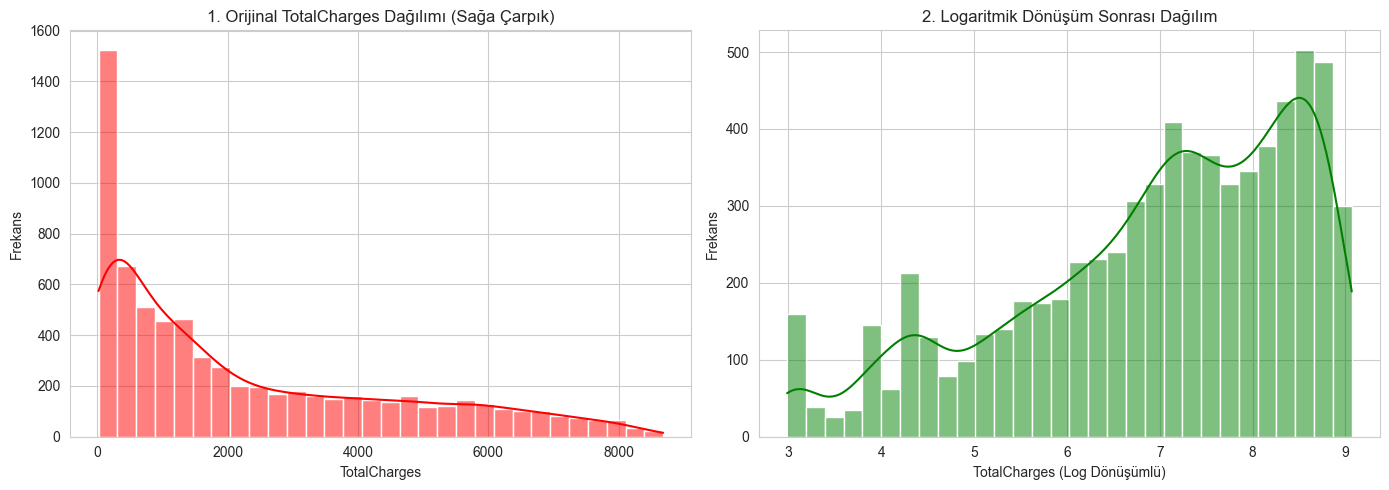

In [21]:
plt.figure(figsize=(14, 5))

# Sol: Orijinal TotalCharges dağılımı (Çarpık)
plt.subplot(1, 2, 1)
sns.histplot(df['TotalCharges'], kde=True, bins=30, color='red')
plt.title('1. Orijinal TotalCharges Dağılımı (Sağa Çarpık)', fontsize=12)
plt.xlabel('TotalCharges')
plt.ylabel('Frekans')

# Sağ: Logaritmik Dönüşüm sonrası dağılım (Normale Yakın)
plt.subplot(1, 2, 2)
sns.histplot(df['TotalCharges_Log'], kde=True, bins=30, color='green')
plt.title('2. Logaritmik Dönüşüm Sonrası Dağılım', fontsize=12)
plt.xlabel('TotalCharges (Log Dönüşümlü)')
plt.ylabel('Frekans')

plt.tight_layout()
plt.show()